# 環境建置

In [ ]:
! pip3 install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://download.pytorch.org/whl/cu126
     ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
     -------------------------------------- - 6.0/6.2 MB 37.0 MB/s eta 0:00:01
     ---------------------------------------- 6.2/6.2 MB 31.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/536.2 kB ? eta -:--:--
     ------------------------------------- 536.2/536.2 kB 18.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.5 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 GB 35.0 MB/s eta 0:01:12
   ---------------------------------------- 0.0/2.5 GB 31.6 MB/s eta 0:01:19
   ---------------------------------------- 0.0/2.5 GB 36.9 MB/s eta 0:01:07
    --------------------------------------- 0.0/2.5 GB 37.0 MB/s eta 0:01:07
    --------------------------------------- 0.0/2.5 GB 36.8 MB/s eta 0:01:07
    --------------------------------------- 0.0/2.5 GB 38.1 MB/s eta 0:01:05
    ------------------------

In [56]:
! pip install -q seaborn
! pip install -q matplotlib

In [ ]:
! pip install -q tensorboard

   ---------------------------------------- 0.0/5.5 MB ? eta -:--:--
   --- ------------------------------------ 0.5/5.5 MB 5.6 MB/s eta 0:00:01
   -------------------------------- ------- 4.5/5.5 MB 16.8 MB/s eta 0:00:01
   ---------------------------------------- 5.5/5.5 MB 16.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   ---------------------------------------- 4.3/4.3 MB 32.1 MB/s eta 0:00:00


In [ ]:
! pip install -q -U scikit-learn

   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ------- -------------------------------- 2.1/11.1 MB 13.0 MB/s eta 0:00:01
   ----------------------------- ---------- 8.1/11.1 MB 22.9 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 25.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/40.9 MB ? eta -:--:--
   ------- -------------------------------- 7.9/40.9 MB 40.7 MB/s eta 0:00:01
   ---------------- ----------------------- 16.8/40.9 MB 40.7 MB/s eta 0:00:01
   ----------------------- ---------------- 24.1/40.9 MB 38.2 MB/s eta 0:00:01
   ------------------------------ --------- 31.7/40.9 MB 38.0 MB/s eta 0:00:01
   ------------------------------------- -- 38.8/40.9 MB 37.4 MB/s eta 0:00:01
   ---------------------------------------- 40.9/40.9 MB 33.0 MB/s eta 0:00:00


In [ ]:
! pip install -q tqdm

In [49]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.6.0+cu126
True


In [5]:
import sys
print(sys.executable)


c:\邪惡小咪的資料夾\深度學習\.venv\Scripts\python.exe


In [6]:
# 設定路徑
train_paths = [".\\train\good"]
test_paths = [
    ".\\test\\\good",
    ".\\test\\broken_large",
    ".\\test\\broken_small",
    ".\\test\contamination"
]

<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:4: SyntaxWarning: invalid escape sequence '\g'
<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:4: SyntaxWarning: invalid escape sequence '\g'
<>:7: SyntaxWarning: invalid escape sequence '\c'
C:\Users\tseng\AppData\Local\Temp\ipykernel_24692\1752115330.py:2: SyntaxWarning: invalid escape sequence '\g'
  train_paths = [".\\train\good"]
C:\Users\tseng\AppData\Local\Temp\ipykernel_24692\1752115330.py:4: SyntaxWarning: invalid escape sequence '\g'
  ".\\test\\\good",
C:\Users\tseng\AppData\Local\Temp\ipykernel_24692\1752115330.py:7: SyntaxWarning: invalid escape sequence '\c'
  ".\\test\contamination"


# 第二題
## 策略一：Autoencoder(Baseline)

In [7]:
# 資料集類別
class MVTecDataset(Dataset):
    def __init__(self, root_dirs, transform=None):
        self.image_paths = []
        for root_dir in root_dirs:
            for fname in sorted(os.listdir(root_dir)):
                if fname.endswith(".png") or fname.endswith(".jpg"):
                    self.image_paths.append(os.path.join(root_dir, fname))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.image_paths[idx]

In [8]:
# 圖片轉換
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 建立資料集與 dataloader
train_dataset = MVTecDataset(train_paths, transform)
test_dataset = MVTecDataset(test_paths, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [9]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),  # 128x128
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 64x64
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # 32x32
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [13]:
from torch.utils.tensorboard import SummaryWriter
device = torch.device("cuda") 
model = Autoencoder().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# TensorBoard 記錄器
writer = SummaryWriter(log_dir="runs/autoencoder_experiment")

# Early Stopping 設定
best_loss = float('inf')
patience = 10
counter = 0
early_stop = False

# 訓練上限（例如 200 epoch）
max_epochs = 200

for epoch in range(1, max_epochs + 1):
    if early_stop:
        print(f"🔔 Early stopping triggered at epoch {epoch}")
        break

    model.train()
    total_loss = 0
    total_pixels = 0
    correct_pixels = 0

    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)

        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 計算 pixel-level accuracy（距離小於 0.05 就視為準確）
        correct_pixels += ((outputs - imgs).abs() < 0.05).sum().item()
        total_pixels += imgs.numel()

    avg_loss = total_loss / len(train_loader)
    train_accuracy = correct_pixels / total_pixels

    # 印出
    print(f"[Epoch {epoch}/{max_epochs}] Loss: {avg_loss:.6f} | Train Acc: {train_accuracy:.4f}")

    # TensorBoard 紀錄
    writer.add_scalar("Loss/train", avg_loss, epoch)
    writer.add_scalar("Accuracy/train", train_accuracy, epoch)

    # Early Stopping 檢查
    if avg_loss < best_loss - 1e-5:
        best_loss = avg_loss
        counter = 0
        torch.save(model.state_dict(), "autoencoder_best.pth")  # 儲存最佳模型
    else:
        counter += 1
        if counter >= patience:
            early_stop = True

writer.close()


[Epoch 1/200] Loss: 0.113473 | Train Acc: 0.0276
[Epoch 2/200] Loss: 0.064047 | Train Acc: 0.0895
[Epoch 3/200] Loss: 0.052511 | Train Acc: 0.2999
[Epoch 4/200] Loss: 0.037398 | Train Acc: 0.3159
[Epoch 5/200] Loss: 0.014974 | Train Acc: 0.4803
[Epoch 6/200] Loss: 0.010640 | Train Acc: 0.5627
[Epoch 7/200] Loss: 0.007296 | Train Acc: 0.5568
[Epoch 8/200] Loss: 0.005370 | Train Acc: 0.6479
[Epoch 9/200] Loss: 0.003933 | Train Acc: 0.6264
[Epoch 10/200] Loss: 0.002789 | Train Acc: 0.7819
[Epoch 11/200] Loss: 0.002426 | Train Acc: 0.7901
[Epoch 12/200] Loss: 0.002320 | Train Acc: 0.7970
[Epoch 13/200] Loss: 0.002228 | Train Acc: 0.8092
[Epoch 14/200] Loss: 0.002173 | Train Acc: 0.8171
[Epoch 15/200] Loss: 0.002130 | Train Acc: 0.8203
[Epoch 16/200] Loss: 0.002087 | Train Acc: 0.8225
[Epoch 17/200] Loss: 0.002043 | Train Acc: 0.8259
[Epoch 18/200] Loss: 0.001980 | Train Acc: 0.8276
[Epoch 19/200] Loss: 0.001884 | Train Acc: 0.8330
[Epoch 20/200] Loss: 0.001786 | Train Acc: 0.8384
[Epoch 21

In [14]:
model.eval()
total_test_loss = 0
total_pixels = 0
correct_pixels = 0

with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)

        loss = criterion(outputs, imgs)
        total_test_loss += loss.item()

        # pixel-level accuracy（誤差小於 0.05 就算正確）
        correct_pixels += ((outputs - imgs).abs() < 0.05).sum().item()
        total_pixels += imgs.numel()

avg_test_loss = total_test_loss / len(test_loader)
test_accuracy = correct_pixels / total_pixels

print(f"Test Loss: {avg_test_loss:.6f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.000360
Test Accuracy: 0.9732


## 策略二：ResNet18 (Frozen)

In [135]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os
import numpy as np

### 載入

In [136]:
resnet18 = models.resnet18(pretrained=True)
feature_extractor = nn.Sequential(*list(resnet18.children())[:-1])
feature_extractor.eval()

c:\邪惡小咪的資料夾\深度學習\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\邪惡小咪的資料夾\深度學習\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [137]:
for param in feature_extractor.parameters():
    param.requires_grad = False

### 影像預處理、特徵提取

In [138]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet 的平均值與標準差
        std=[0.229, 0.224, 0.225]
    )
])

In [139]:
def extract_feature(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)  # 增加 batch 維度
    with torch.no_grad():
        feature = feature_extractor(input_tensor)
    return feature.squeeze().flatten().numpy()  # 取出2048維向量

In [140]:
good_images_dir = r'./train/good/'
good_features = []

for img_name in os.listdir(good_images_dir):
    img_path = os.path.join(good_images_dir, img_name)
    feature = extract_feature(img_path)
    good_features.append(feature)

good_features = np.array(good_features)

### 訓練One-Class SVM

In [141]:
from sklearn.svm import OneClassSVM

# 建立與訓練模型（可調整 nu、kernel）
oc_svm = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
oc_svm.fit(good_features)

OneClassSVM(nu=0.05)

### test

In [142]:
test_image_path = ['./test/good/',
                   './test/broken_large',
                   './test/broken_small',
                   './test/contamination']
image_label = []
for img_name in os.listdir(test_image_path[0]):
    img_path = os.path.join(test_image_path[0], img_name)
    feature = extract_feature(img_path)
    image_label.append((feature, 1))
for path in test_image_path[1:]:
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        feature = extract_feature(img_path)
        image_label.append((feature, -1))

In [143]:
count = 0
acc_count = 0
TP, TN, FP, FN = 0, 0, 0, 0
for feature, label in image_label:
    count += 1
    pred = oc_svm.predict(feature.reshape(1, -1))[0]
    if label == pred:
        acc_count += 1
    if pred ==1 and label == 1:
        TP += 1
    elif pred == 1 and label == -1:
        FP += 1
    elif pred == -1 and label == -1:
        TN += 1
    elif pred == -1 and label == 1:
        FN += 1
test_accuracy = acc_count / count
print(f'test accuracy: {test_accuracy:.4f}')

test accuracy: 0.9277


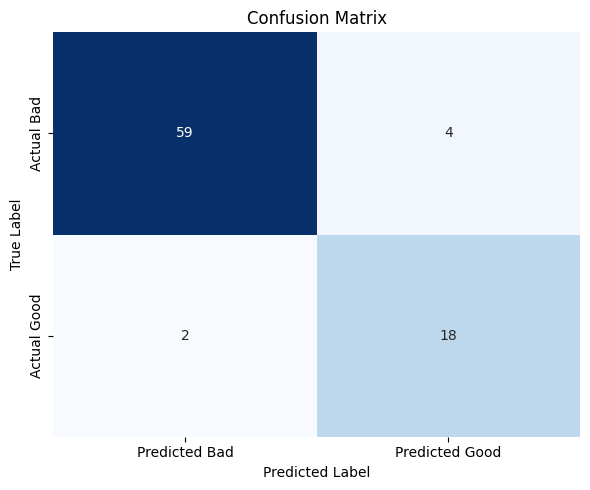

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = np.array([[TN, FP],
               [FN, TP]])

# 繪製熱力圖
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Bad', 'Predicted Good'],
            yticklabels=['Actual Bad', 'Actual Good'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## 策略三： ResNet18 (Fine-Tuning)

In [145]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from PIL import Image
import os
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 載入

In [146]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet 的平均值與標準差
        std=[0.229, 0.224, 0.225]
    )
])

In [147]:
train_dataset = datasets.ImageFolder(root="train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_dataset = datasets.ImageFolder(root="test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print(test_dataset.class_to_idx)

{'broken_large': 0, 'broken_small': 1, 'contamination': 2, 'good': 3}


In [148]:
resnet18 = models.resnet18(pretrained=True)
for param in feature_extractor.parameters():
    param.requires_grad = False
# 解凍 layer4（最後一層 CNN）
for name, param in resnet18.named_parameters():
    if "layer4" in name:
        param.requires_grad = True
encoder = nn.Sequential(*list(resnet18.children())[:-2])

c:\邪惡小咪的資料夾\深度學習\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\邪惡小咪的資料夾\深度學習\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### decoder

In [149]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),  # 7x7 → 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # 14x14 → 28x28
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),   # 28x28 → 56x56
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),    # 56x56 → 112x112
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),     # 112x112 → 224x224
            nn.Sigmoid()  # 輸出為 [0,1]
        )
    def forward(self, x):
        return self.decoder(x)

autoencoder = nn.Sequential(encoder, Decoder()).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, autoencoder.parameters()), lr=1e-3)
loss_fn = nn.MSELoss()

### finetune

In [150]:
best_model_path = 'resnet18_finetune_lastlayer.pth'
best_loss = float('inf')
early_count = 0
early_stop = 5
for epoch in range(50):
    autoencoder.train()
    epoch_loss = 0
    for img, _ in train_loader:  # 你需要用 DataLoader 包裝 good 資料
        img = img.to(device)
        optimizer.zero_grad()
        out = autoencoder(img)
        loss = loss_fn(out, img)  # 重建誤差
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        early_count = 0
        torch.save(autoencoder.state_dict(), best_model_path)  # 儲存目前模型
    else: 
        early_count += 1
        if early_count >= early_stop:
            print(f'{early_stop} steps no improve, early stop')
            break
autoencoder.load_state_dict(torch.load(best_model_path))

Epoch 1, Loss: 24.4435
Epoch 2, Loss: 21.5617
Epoch 3, Loss: 19.8338
Epoch 4, Loss: 15.0867
Epoch 5, Loss: 14.5358
Epoch 6, Loss: 14.4713
Epoch 7, Loss: 14.4519
Epoch 8, Loss: 14.4311
Epoch 9, Loss: 14.4299
Epoch 10, Loss: 14.4161
Epoch 11, Loss: 14.4238
Epoch 12, Loss: 14.4164
Epoch 13, Loss: 14.4121
Epoch 14, Loss: 14.4041
Epoch 15, Loss: 14.4162
Epoch 16, Loss: 14.4004
Epoch 17, Loss: 14.4162
Epoch 18, Loss: 14.4196
Epoch 19, Loss: 14.4121
Epoch 20, Loss: 14.4080
Epoch 21, Loss: 14.4045
5 steps no improve, early stop


<All keys matched successfully>

In [151]:
autoencoder.eval()
feature_list = []

with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        feat = encoder(x)
        feat = feat.view(x.size(0), -1).cpu().numpy()
        feature_list.append(feat)

X_train_feat = np.concatenate(feature_list, axis=0)

### 訓練One-Class SVM

In [152]:
from sklearn.svm import OneClassSVM

# 建立與訓練模型（可調整 nu、kernel）
oc_svm = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
oc_svm.fit(X_train_feat)

OneClassSVM(nu=0.05)

### test

In [153]:
y_true = []
y_pred = []

with torch.no_grad():
    for x, label in test_loader:
        x = x.to(device)
        feat = encoder(x)
        feat = feat.view(1, -1).cpu().numpy()
        pred = (oc_svm.predict(feat)[0] + 1) // 2  # 轉成 0/1
        y_pred.append(pred)
        y_true.append(label.item() // 3)  # 假設 test set 分類為 good:3, anomaly:0 1 2

✅ Accuracy: 0.61
Confusion Matrix:
 [[31 32]
 [ 0 20]]


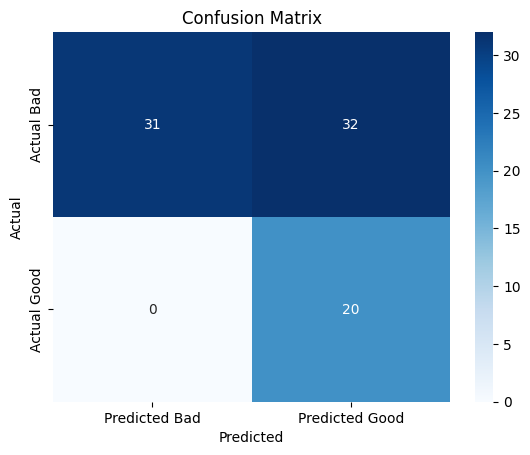

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"✅ Accuracy: {acc:.2f}")
print("Confusion Matrix:\n", cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Bad', 'Predicted Good'],
            yticklabels=['Actual Bad', 'Actual Good'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 策略四：ResNet50(Frozen)

In [155]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os
import numpy as np

### 載入

In [156]:
resnet50 = models.resnet50(pretrained=True)
feature_extractor = nn.Sequential(*list(resnet50.children())[:-1])
feature_extractor.eval()

c:\邪惡小咪的資料夾\深度學習\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\邪惡小咪的資料夾\深度學習\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [157]:
for param in feature_extractor.parameters():
    param.requires_grad = False

### 影像預處理、特徵提取

In [158]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet 的平均值與標準差
        std=[0.229, 0.224, 0.225]
    )
])

In [159]:
def extract_feature(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)  # 增加 batch 維度
    with torch.no_grad():
        feature = feature_extractor(input_tensor)
    return feature.squeeze().flatten().numpy()  # 取出2048維向量

In [160]:
good_images_dir = r'./train/good/'
good_features = []

for img_name in os.listdir(good_images_dir):
    img_path = os.path.join(good_images_dir, img_name)
    feature = extract_feature(img_path)
    good_features.append(feature)

good_features = np.array(good_features)

### 訓練One-Class SVM

In [161]:
from sklearn.svm import OneClassSVM

# 建立與訓練模型（可調整 nu、kernel）
oc_svm = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
oc_svm.fit(good_features)

OneClassSVM(nu=0.05)

### test

In [162]:
test_image_path = ['./test/good/',
                   './test/broken_large',
                   './test/broken_small',
                   './test/contamination']
image_label = []
for img_name in os.listdir(test_image_path[0]):
    img_path = os.path.join(test_image_path[0], img_name)
    feature = extract_feature(img_path)
    image_label.append((feature, 1))
for path in test_image_path[1:]:
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        feature = extract_feature(img_path)
        image_label.append((feature, -1))

In [163]:
count = 0
acc_count = 0
TP, TN, FP, FN = 0, 0, 0, 0
for feature, label in image_label:
    count += 1
    pred = oc_svm.predict(feature.reshape(1, -1))[0]
    if label == pred:
        acc_count += 1
    if pred ==1 and label == 1:
        TP += 1
    elif pred == 1 and label == -1:
        FP += 1
    elif pred == -1 and label == -1:
        TN += 1
    elif pred == -1 and label == 1:
        FN += 1
test_accuracy = acc_count / count
print(f'test accuracy: {test_accuracy:.4f}')

test accuracy: 0.8675


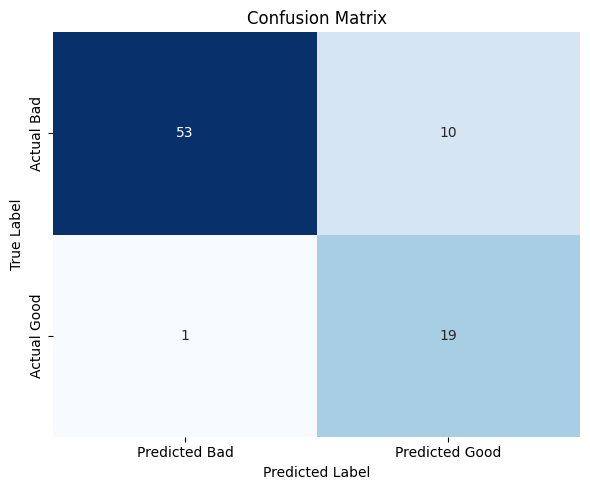

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = np.array([[TN, FP],
               [FN, TP]])

# 繪製熱力圖
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Bad', 'Predicted Good'],
            yticklabels=['Actual Bad', 'Actual Good'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# 第三題